In [49]:
import timeit
import numpy as np
import random
import sys
import os
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
sys.path.append('../models/')
import sentiment as sentimentinterface
import classify as classify
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [51]:
print("Reading data")
filepath = "../data/bbc/"
dirs = os.listdir(filepath)
dirs =[d for d in dirs if "README.TXT" not in d]
# read all the files
classes = ['sport', 'tech', 'business', 'politics', 'entertainment']
data = []
label = []
for d in dirs:
    files = os.listdir(filepath+d)
    for fi in files:
        with open(filepath+d+'/'+fi, 'r', encoding="utf8", errors='ignore') as f:
            lines = f.readlines()
            f.close()
        lines = [l.strip() for l in lines]
        lines = " ".join(lines)
        data.append(lines)
        label.append(classes.index(d))
        
assert(len(data)==len(label))

# shuffle the data and split into train and dev set
random.Random(123).shuffle(data)
random.Random(123).shuffle(label)
indx = 0.7*len(data)
train_data = data[:int(indx)]
trainy = label[:int(indx)]
dev_data = data[int(indx):]
devy = label[int(indx):]

print('TfidfVectorizer:')
count_vect = TfidfVectorizer(
    max_features = 200000, min_df = 1, max_df = 1.0, 
    tokenizer = LemmaTokenizer(), sublinear_tf = False, 
    ngram_range = (1, 3), stop_words = frozenset(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from']))

trainX = count_vect.fit_transform(train_data)
devX = count_vect.transform(dev_data)

Reading data
TfidfVectorizer:


In [52]:
print("\nTraining classifier")
cval = 8
clf = classify.train_classifier(trainX, trainy, cval, 'l2','lbfgs')
print('Training input shape: ' + str(trainX.shape))
print("\nEvaluating")
train_acc, train_prob, train_pred = classify.evaluate(trainX, trainy, clf, name = 'training data')
dev_acc, dev_prob, dev_pred = classify.evaluate(devX, devy, clf, name = 'validation data')
print('Train accuracy: ' + str(train_acc))
print('Dev accuracy: ' + str(dev_acc))


Training classifier
Training input shape: (1557, 200000)

Evaluating
Train accuracy: 1.0
Dev accuracy: 0.9805389221556886


## 1.1 How confident our model is in prediction?

In [53]:
def find_correct_incorrect(pred_prob, pred_lb, gt_lb, conf_score=0.8):
    """
    Use given confidence score as threshold for treating a given prediction confident.
    Then, returns the percentage of confident samples pedicted correctly and incorrectly.
    """
    confident_pred = []
    nconfident_pred = []
    for idx in range(len(pred_prob)):
        if max(pred_prob[idx]) >= conf_score:
            confident_pred.append(idx)
        else:
            nconfident_pred.append(idx)

    # classifier is confident about predictions on this much percentage
    confident_perc = round(100*len(confident_pred)/len(pred_prob), 2)
    nconfident_perc = 100. - confident_perc
    print("Classifier is confident about {}% of predictions".format(confident_perc))
    
    # classifier is correct/incorrect on confident predictions
    confident_corr = 0
    confident_incorr = 0
    for idx in confident_pred:
        if(gt_lb[idx] == pred_lb[idx]):
            confident_corr += 1
        else:
            confident_incorr += 1

    
    correct_perc = round(100*confident_corr/len(confident_pred), 2)
    incorrect_perc = round(100*confident_incorr/len(confident_pred), 2)
    print("Classifier is correct {}% times on confident predictions".format(correct_perc))
    print("Classifier is incorrect {}% times on confident predictions".format(incorrect_perc))
    
    # classifier is correct/incorrect on not-confident predictions
    print("Classifier is not confident about {}% of predictions".format(nconfident_perc))
    nconfident_corr = 0
    nconfident_incorr = 0
    for idx in nconfident_pred:
        if(gt_lb[idx] == pred_lb[idx]):
            nconfident_corr += 1
        else:
            nconfident_incorr += 1
    
    ncorrect_perc = round(100*nconfident_corr/len(nconfident_pred), 2)
    nincorrect_perc = round(100*nconfident_incorr/len(nconfident_pred), 2)
    print("Classifier is correct {}% times on non-confident predictions".format(ncorrect_perc))
    print("Classifier is incorrect {}% times on non-confident predictions".format(nincorrect_perc))
    
    return confident_perc, correct_perc, incorrect_perc, nconfident_perc, ncorrect_perc, nincorrect_perc
    

In [54]:
CONF_TH=0.8
conf_pred, conf_predc, conf_predinc, nconf_pred, nconf_predc, nconf_predinc = \
        find_correct_incorrect(dev_prob, dev_pred, devy, CONF_TH)

Classifier is confident about 72.9% of predictions
Classifier is correct 100.0% times on confident predictions
Classifier is incorrect 0.0% times on confident predictions
Classifier is not confident about 27.099999999999994% of predictions
Classifier is correct 92.82% times on non-confident predictions
Classifier is incorrect 7.18% times on non-confident predictions


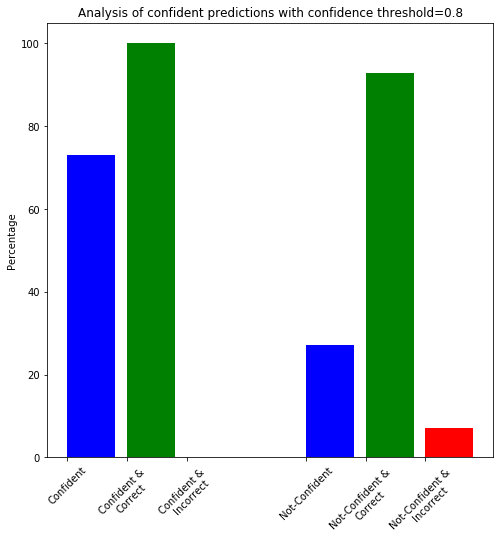

In [55]:
x_conf = [0, 1, 2]
x_nconf = [4, 5, 6]
scores_conf = [conf_pred, conf_predc, conf_predinc]
scores_nconf = [nconf_pred, nconf_predc, nconf_predinc]

plt.figure(1,figsize=(8, 8))
plt.bar(x_conf+x_nconf, scores_conf+scores_nconf, color = ('b', 'g', 'r', 'b', 'g', 'r'), align='edge')

#plt.bar(x_nconf, scores_nconf, color = ('b', 'g', 'r'), align='edge')
# Text on the top of each barplot
#for i in range(len(x_)):
#    plt.text(x = x_[i] , y = x_[i], s = scores_[i], size = 15, color='white')

plt.xticks(x_conf + x_nconf, 
          ('Confident', 'Confident & \nCorrect', 'Confident & \n Incorrect',
           'Not-Confident', 'Not-Confident & \nCorrect', 'Not-Confident & \n Incorrect'), rotation=45)

plt.ylabel('Percentage')
plt.title('Analysis of confident predictions with confidence threshold='+str(CONF_TH))
plt.savefig('../graph/confidence.png', format='png', dpi=100)

## 1.2 Top K words for each class in given input that affect prediction?

In [58]:
def plot_topk_wordcloud(clf, feat_names, k=10, clas='sport'):
    coefficients=clf.coef_[classes.index(clas)]
    top_k=np.argsort(coefficients)[-k:]

    top_k_words = []
    for i in top_k:
        #print(feat_names[i], coefficients[i])
        top_k_words.append(feat_names[i])
    
    words = " ".join(top_k_words)
    # TODO: if required to scale frequency of words as per weights
    # plot wordcloud
    wordcloud = WordCloud(
            stopwords=STOPWORDS, background_color='white', width=500, height=500).generate(words)
    plt.figure(1,figsize=(5, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Top '+ str(k) + ' ' + clas + ' words', size=15)
    plt.savefig('../graph/' + clas + '.png', format='png', dpi=200)

In [59]:
classes

['sport', 'tech', 'business', 'politics', 'entertainment']

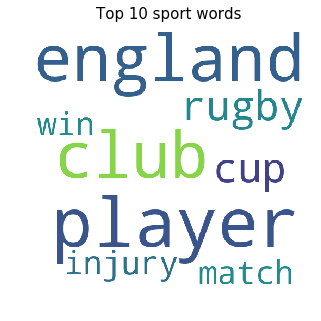

In [60]:
feat_names = count_vect.get_feature_names()
plot_topk_wordcloud(clf, feat_names, 10, 'sport')

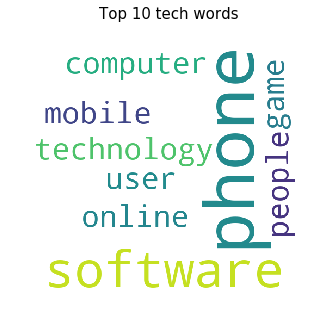

In [61]:
plot_topk_wordcloud(clf, feat_names, 10, 'tech')

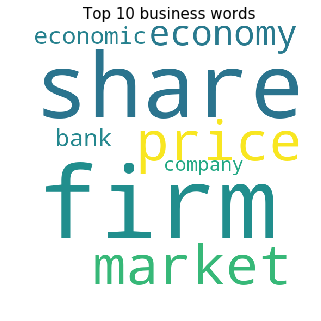

In [62]:
plot_topk_wordcloud(clf, feat_names, 10, 'business')

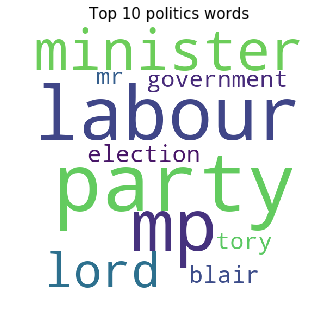

In [63]:
plot_topk_wordcloud(clf, feat_names, 10, 'politics')

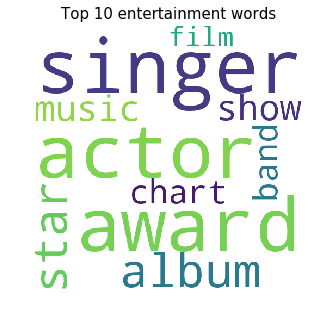

In [64]:
plot_topk_wordcloud(clf, feat_names, 10, 'entertainment')

## 1.3 Analysis of prediction of given input to trained model?

In [65]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

In [89]:
input1 = dev_data[3]
class1 = classes[devy[3]]
print("Input1:", class1)

input2 = dev_data[10]
class2 = classes[devy[10]]
print("Input2:", class2)

input3 = dev_data[12]
class3 = classes[devy[12]]
print("Input3:", class3)

input4 = dev_data[14]
class4 = classes[devy[14]]
print("Input4:", class4)

input5 = dev_data[47]
class5 = classes[devy[47]]
print("Input5:", class5)

Input1: entertainment
Input2: business
Input3: sport
Input4: politics
Input5: tech


In [75]:
def plot_lime(sen_input, clf, clas, vectorizer=count_vect):
    c = make_pipeline(vectorizer, clf)
    class_names = classes
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(sen_input, c.predict_proba, num_features=8, top_labels=1)
    exp.show_in_notebook(text=True)
    exp.save_to_file('../graph/input_ouput_'+clas+'.html')
    #exp.as_pyplot_figure()

In [90]:
plot_lime(input1, clf, class1)

/home/amanraj/anaconda3/envs/neural/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [91]:
plot_lime(input2, clf, class2)

/home/amanraj/anaconda3/envs/neural/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [92]:
plot_lime(input3, clf, class3)

/home/amanraj/anaconda3/envs/neural/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [93]:
plot_lime(input4, clf, class4)

/home/amanraj/anaconda3/envs/neural/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [94]:
plot_lime(input5, clf, class5)

/home/amanraj/anaconda3/envs/neural/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
